<h1>US Incomve Vs Pollution – K. Sawczuk </h1>
<h2>Predicting Income Based on Air Pollution Levels in US Counties</h2>

<h3>Hypothesis:</h3>
<h4>Household income on a US county level can be predicted based on air pollution from current and previous years.</h4>

<h3>Background</h3>
Air pollution is the measure of the concentration of several chemicals and particulates in the air. A few of the 
most common substances monitored to determine air pollution levels are:
<ul>
    <li>Carbon Monoxide (CO),
    <li>Ozone (O3),
    <li>Nitrous Dioxide (NO2),
    <li>Sulfur Dioxide (SO2),
    <li>PM 2.5,
    <li>PM 10.
</ul>
Note that Carbon Dioxide, Methane and other greenhouse gasses aren't listed. That's because greenhouse gasses 
cause climate change, not what we refer to as air pollution.

<br>
<h3>Assumptions / Limitations</h3>
<ul>
    <li>Averaging pollution levels while grouping will remove readings of heavy pollution.
    <li>It will be more useful to count the instances of pollution levels being read at different AQI levels.
    <li>I've spent a lot of time cleaning and preparing data, I would say that is the highlight of this project.
</ul>

<h3>Method</h3>
<ol>
    <li>gather and clean data sources.
    <li>examine data and look for relationships between columnns.
    <li>choose a model and implement.
    <li>validate the model.
    <li>if required iterate via:
        <ul>
            <li>adding or changing independent variables of model.
            <li>changing model type.
            <li>re-validate model.
        </ul>
    <li>conclusion / next steps
</ol>
<h3>Data Sources:</h3>
<ol>
    <li>Kaggle data set, pollution_us_2000_2016.csv
    https://www.kaggle.com/sogun3/uspollution
    <li>State and County Estimates of Household Income and Poverty – from US Census Bureau – Small Area Income and Poverty Estimates (SAIPE)
    https://www.census.gov/data/datasets/2003/demo/saipe/2003-state-and-county.html
</ol>


In [1]:
#enviornment setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime


%matplotlib inline
sns.set_style('whitegrid') # set a style
pd.options.display.max_columns = None 
pd.options.display.width=None

<h3>Massaging the Income data sets</h3>
<ol>
    <li>Read the sets while being able to handle variable column names, variable header rows, sometimes a footer row.
    <li>Standardize column names.
    <li>Drop rows with less than three numeric data points.
    <li>Pad State FIPS and County FIPS Codes to be two and three digit respectively
    <li>Remove all commas from the sheet.
    <li>Remove Kalawao county row.
    <li>If sorting by County then drop US and State rows.
    <li>Create GEO_ID using State and County FIPS.
    <li>If sorting by State then drop all county rows.
    <li>Create GEO_ID using State FIPS only.
    <li>Drop columns associated with State and US rows.
    <li>Reset index.
    <li>Add Year column, make each entry format as YYYY-01-01.
    <li>Change data types.
    <li>Concat all 14 datasets into 1.
    <li>Drop additional unneeded columns.  
        
</ol>

In [2]:
#Method to change all data types in sets.
def change_types(income_data):
    col_types = ['string', 'string', 'string', 'string', 'float64', 'float64', 'float64', 'float64', 'float64',
             'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 
             'float64', 'float64','float64', 'float64', 'float64', 'float64', 'float64', 'string', 'datetime64[ns]'] 
    #all col types after import and all other changes.
    
    column_types_d = {income_data.columns[i]: col_types[i] for i in range(len(income_data.columns))}
    income_data = income_data.astype(column_types_d)
    
    return income_data

In [3]:
#Method to change column names in all data sets for standardization.
def change_col_titles(income_data):
    income_col_names = ['State FIPS', 'County FIPS', 'Postal Code', 'Name', 
                              'Poverty Estimate All Ages', '90% CI Lower Bound', 
                              '90% CI Upper Bound', 'Poverty_Percent_All_Ages','90% CI Lower Bound.1', 
                              '90% CI Upper Bound.1', 'Poverty Estimate Under Age 18', 
                              '90% CI Lower Bound.2', '90% CI Upper Bound.2','Poverty Percent Under Age 18',
                              '90% CI Lower Bound.3', '90% CI Upper Bound.3',
                              'Poverty Estimate Ages 5-17', '90% CI Lower Bound.4',
                              '90% CI Upper Bound.4', 'Poverty Percent Ages 5-17', '90% CI Lower Bound.5', 
                              '90% CI Upper Bound.5', 'Median_Household_Income',
                              '90% CI Lower Bound.6', '90% CI Upper Bound.6','Poverty Estimate Ages 0-4',
                              '90% CI Lower Bound.7', '90% CI Upper Bound.7', 'Poverty Percent Ages 0-4', 
                              '90% CI Lower Bound.8', '90% CI Upper Bound.8']
    
    column_dictionary = {income_data.columns[i]: income_col_names[i] for i in range(len(income_col_names))}
    income_data = income_data.rename(columns = column_dictionary)
    
    return income_data

In [4]:
# A method that will load and clean the income datasets from 03 - 16. 
# call change_types and col_names from within the function.
# I ended up removing some initial rows from the CSV file as I was having a lot of problems abstracting
# the function where there is a variable number of rows in the header. 

def clean_income(file_dict, method): #Where method 1 = filter by State, 2 = filter by County.
    income_data_list = []
    income_vars_list = ['income_03', 'income_04', 'income_05', 'income_06', 'income_07', 'income_08',
                   'income_09', 'income_10', 'income_11', 'income_12', 'income_13', 'income_14',
                   'income_15', 'income_16']
    
    for x in file_dict:
#Read file, deal with variable header length (1 row or 2), stipulate string as type for state and county FIPS.
        income_work = pd.read_csv(x, skiprows = 1, dtype = 
                             {'State FIPS':'string', 'State FIPS Code':'string', 'County FIPS':'string', 'County FIPS Code':'string'})
        if income_work.columns[0] != 'State FIPS' and income_work.columns[0] != 'State FIPS Code':
            income_work = pd.read_csv(x, skiprows = 2, 
                              dtype = {'State FIPS':'string', 'State FIPS Code':'string', 'County FIPS':'string', 'County FIPS Code':'string'})

#Change column titles to standardized names.
        income_work = change_col_titles(income_work)
#Remove any remaining NaN Rows.
        income_work = income_work.dropna(thresh = 3, axis = 0)
#Pad state FIPS.
        income_work['State FIPS']= income_work['State FIPS'].apply(lambda x: '{0:0>2}'.format(x)) 
#Pad county FIPS.
        income_work['County FIPS']= income_work['County FIPS'].apply(lambda x: '{0:0>3}'.format(x)) 
#Remove all commas.
        income_work = income_work.replace(',', '', regex = True)
#Remove Kalawao County row (contains no data).
        income_work.drop(income_work.loc[income_work['Name'].isin(['Kalawao County'])].index, inplace = True, axis = 0) 
        if method == 1:
            #Remove all County rows and the US row, leave state rows.
            income_work = income_work.loc[(income_work['County FIPS'] == '000') & (income_work['Name'] != 'United States')]
            #Add GEO_ID column and popluate with GEO_ID from State and County FIPS = '000'.
            income_work['GEO_ID'] = '0500000US' + income_work['State FIPS'] + '000'
        elif method == 2:
            #Remove USA and State Total Rows.
            income_work.drop(income_work.loc[income_work['County FIPS'].isin(['000'])].index, inplace = True)
            #Add GEO_ID column and popluate with GEO_ID from State and County FIPS.
            income_work['GEO_ID'] = '0500000US' + income_work['State FIPS'] + income_work['County FIPS']
#Remove USA and State specific columns.
        income_work.drop(['Poverty Estimate Ages 0-4','90% CI Lower Bound.7','90% CI Upper Bound.7',
                 'Poverty Percent Ages 0-4','90% CI Lower Bound.8','90% CI Upper Bound.8'], axis = 1, inplace = True)
#Reset Index.
        income_work.reset_index(drop = True)
#Add Year column, populate with year.
        income_work['Year'] = file_dict.get(x)
#Change data types to numeric and or string.
        income_work = change_types(income_work)
#Append cleaned data file to list of results.
        income_data_list.append(income_work)
#Print dtypes for each DataFrame.
        print(income_work.dtypes)
#return results as a dictionary of DataFrames.
    income_dict = {income_vars_list[i]: income_data_list[i] for i in range(len(income_vars_list))}
    return income_dict

In [5]:
#Create file, year dictionary to feed to clean_income
files = ['data/US_Income/est03all.csv', 'data/US_Income/est04all.csv', 'data/US_Income/est05all.csv', 'data/US_Income/est06all.csv',
        'data/US_Income/est07all.csv', 'data/US_Income/est08all.csv', 'data/US_Income/est09all.csv', 'data/US_Income/est10all.csv',
        'data/US_Income/est11all.csv', 'data/US_Income/est12all.csv', 'data/US_Income/est13all.csv', 'data/US_Income/est14all.csv', 
        'data/US_Income/est15all.csv', 'data/US_Income/est16all.csv']

years = ['2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
         '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01']

data_dict = {files[i]:years[i] for i in range(len(files))}

In [6]:
# Call clean_income() and receive the transformed sets in dictionary format.
# Method 1 = sort by State, Method 2 = sort by County.
income_set = {}
method = 2
income_set = clean_income(data_dict, method)

State FIPS                               string
County FIPS                              string
Postal Code                              string
Name                                     string
Poverty Estimate All Ages               float64
90% CI Lower Bound                      float64
90% CI Upper Bound                      float64
Poverty_Percent_All_Ages                float64
90% CI Lower Bound.1                    float64
90% CI Upper Bound.1                    float64
Poverty Estimate Under Age 18           float64
90% CI Lower Bound.2                    float64
90% CI Upper Bound.2                    float64
Poverty Percent Under Age 18            float64
90% CI Lower Bound.3                    float64
90% CI Upper Bound.3                    float64
Poverty Estimate Ages 5-17              float64
90% CI Lower Bound.4                    float64
90% CI Upper Bound.4                    float64
Poverty Percent Ages 5-17               float64
90% CI Lower Bound.5                    

In [7]:
# Concatenate income data sets into one.
income = pd.concat(income_set.values(), ignore_index = True) 

In [8]:
income.shape

(43974, 27)

In [9]:
income.columns

Index(['State FIPS', 'County FIPS', 'Postal Code', 'Name',
       'Poverty Estimate All Ages', '90% CI Lower Bound', '90% CI Upper Bound',
       'Poverty_Percent_All_Ages', '90% CI Lower Bound.1',
       '90% CI Upper Bound.1', 'Poverty Estimate Under Age 18',
       '90% CI Lower Bound.2', '90% CI Upper Bound.2',
       'Poverty Percent Under Age 18', '90% CI Lower Bound.3',
       '90% CI Upper Bound.3', 'Poverty Estimate Ages 5-17',
       '90% CI Lower Bound.4', '90% CI Upper Bound.4',
       'Poverty Percent Ages 5-17', '90% CI Lower Bound.5',
       '90% CI Upper Bound.5', 'Median_Household_Income',
       '90% CI Lower Bound.6', '90% CI Upper Bound.6', 'GEO_ID', 'Year'],
      dtype='object')

In [10]:
#Removes unnecessary columns.
unnecessary = ['State FIPS', 'County FIPS', 'Postal Code', 
       'Poverty Estimate All Ages', '90% CI Lower Bound', '90% CI Upper Bound',
       '90% CI Lower Bound.1',
       '90% CI Upper Bound.1', 'Poverty Estimate Under Age 18',
       '90% CI Lower Bound.2', '90% CI Upper Bound.2',
       'Poverty Percent Under Age 18', '90% CI Lower Bound.3',
       '90% CI Upper Bound.3', 'Poverty Estimate Ages 5-17',
       '90% CI Lower Bound.4', '90% CI Upper Bound.4',
       'Poverty Percent Ages 5-17', '90% CI Lower Bound.5',
       '90% CI Upper Bound.5', '90% CI Lower Bound.6', '90% CI Upper Bound.6']
income.drop(unnecessary, axis = 1, inplace = True)

<AxesSubplot:xlabel='Year', ylabel='Median_Household_Income'>

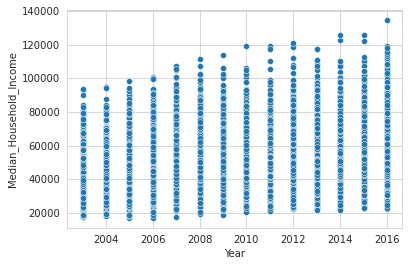

In [11]:
sns.scatterplot(data=income, x='Year', y='Median_Household_Income')

<AxesSubplot:xlabel='Year', ylabel='Poverty_Percent_All_Ages'>

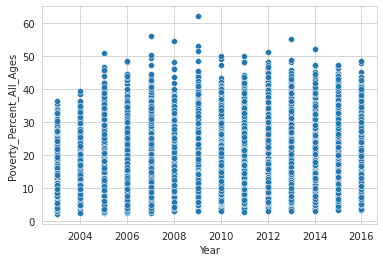

In [12]:
sns.scatterplot(data=income, x='Year', y='Poverty_Percent_All_Ages')

In [13]:
income.sort_values(['Name', 'Year'], inplace=True, ignore_index=True)

In [14]:
income.head(10)

,Name,Poverty_Percent_All_Ages,Median_Household_Income,GEO_ID,Year
0,Abbeville County,13.6,30578.0,0500000US45001,2003-01-01
1,Abbeville County,15.1,31362.0,0500000US45001,2004-01-01
2,Abbeville County,19.2,32486.0,0500000US45001,2005-01-01
3,Abbeville County,18.1,34610.0,0500000US45001,2006-01-01
4,Abbeville County,17.4,35993.0,0500000US45001,2007-01-01
5,Abbeville County,17.6,36041.0,0500000US45001,2008-01-01
6,Abbeville County,19.7,33995.0,0500000US45001,2009-01-01
7,Abbeville County,19.1,34658.0,0500000US45001,2010-01-01
8,Abbeville County,20.4,36787.0,0500000US45001,2011-01-01
9,Abbeville County,20.2,35456.0,0500000US45001,2012-01-01


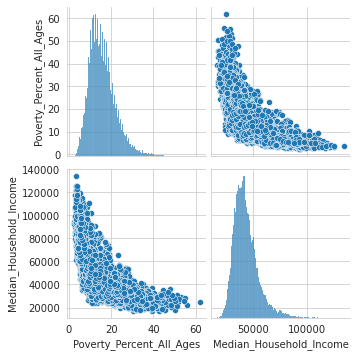

In [15]:
sns.pairplot(income)

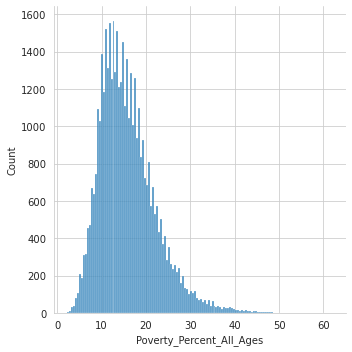

In [17]:
sns.displot(income['Poverty_Percent_All_Ages'], kde = False)

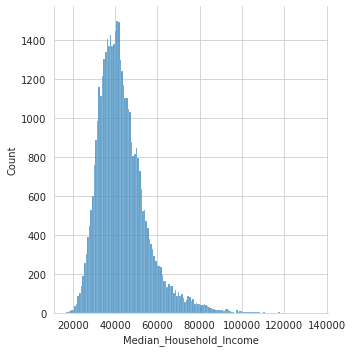

In [19]:
sns.displot(income['Median_Household_Income'], kde = False)

<h3>Income Dataset Results</h3>
This all seemed to work very well. We have an observation from almost every County in the US for every year between 2003 and 2016.

<h3>Data cleaning to perform for pollution:</h3>
<ol>
    <li>Parse date to datetime dtype on read.
    <li>Initially read only data columns including AQI for each sensor type (for simplicity, can re-read later if other columns needed).
    <li>Pad State and County Codes to two digits and three digits respectively.
    <li>Create GEO_ID for County level or State level depending on input arguments (to quickly change grouping to County or State Level).
    <li>Rename column names, remove spaces and replace with '_'.
    <li>Create AQI hit counts for all pollutant AQIs. This should be better than averaging as high pollution levels will be lost with average.
    <li>Groupby either State or County depending on input arguments, 
        <ul>
            <li>Resample date to yearly to match with income.
            <li>For aggregation, take mean of pollutant AQIs and sum of AQI hit counts.
            <li>Reset index.
        </ul>
</ol>

In [20]:
# count_instances will take the original pollution data set and add a value where a reading falls into the EPA's AQI table (see below).

def count_instances(pollution):
    # O3 AQI Counts
    pollution['Gd_O3'] = np.where(((pollution['O3_AQI'] >= 0) & (pollution['O3_AQI'] < 51)), 1,0)                  
    pollution['Md_O3'] = np.where(((pollution['O3_AQI'] >= 51) & (pollution['O3_AQI'] < 101)), 1,0)                                    
    pollution['UnhSG_O3'] = np.where(((pollution['O3_AQI'] >= 101) & (pollution['O3_AQI'] < 151)), 1,0)
    pollution['Unh_O3'] = np.where(((pollution['O3_AQI'] >= 151) & (pollution['O3_AQI'] < 201)), 1,0)
    pollution['VUnh_O3'] = np.where(((pollution['O3_AQI'] >= 201) & (pollution['O3_AQI'] < 301)), 1,0)
    pollution['Hzrd_O3'] = np.where((pollution['O3_AQI'] >= 301), 1, 0) 
    
    # CO AQI Counts
    pollution['Gd_CO'] = np.where(((pollution['CO_AQI'] >= 0) & (pollution['CO_AQI'] < 51)), 1,0)                  
    pollution['Md_CO'] = np.where(((pollution['CO_AQI'] >= 51) & (pollution['CO_AQI'] < 101)), 1,0)                                   
    pollution['UnhSG_CO'] = np.where(((pollution['CO_AQI'] >= 101) & (pollution['CO_AQI'] < 151)), 1,0)
    pollution['Unh_CO'] = np.where(((pollution['CO_AQI'] >= 151) & (pollution['CO_AQI'] < 201)), 1,0)
    pollution['VUnh_CO'] = np.where(((pollution['CO_AQI'] >= 201) & (pollution['CO_AQI'] < 301)), 1,0)
    pollution['Hzrd_CO'] = np.where((pollution['CO_AQI'] >= 301), 1, 0)
    
    # SO2 AQI Counts
    pollution['Gd_SO2'] = np.where(((pollution['SO2_AQI'] >= 0) & (pollution['SO2_AQI'] < 51)), 1,0)                  
    pollution['Md_SO2'] = np.where(((pollution['SO2_AQI'] >= 51) & (pollution['SO2_AQI'] < 101)), 1,0)                                   
    pollution['UnhSG_SO2'] = np.where(((pollution['SO2_AQI'] >= 101) & (pollution['SO2_AQI'] < 151)), 1,0)
    pollution['Unh_SO2'] = np.where(((pollution['SO2_AQI'] >= 151) & (pollution['SO2_AQI'] < 201)), 1,0)
    pollution['VUnh_SO2'] = np.where(((pollution['SO2_AQI'] >= 201) & (pollution['SO2_AQI'] < 301)), 1,0)
    pollution['Hzrd_SO2'] = np.where((pollution['SO2_AQI'] >= 301), 1, 0)
    
    # NO2 AQI Counts
    pollution['Gd_NO2'] = np.where(((pollution['NO2_AQI'] >= 0) & (pollution['NO2_AQI'] < 51)), 1,0)                  
    pollution['Md_NO2'] = np.where(((pollution['NO2_AQI'] >= 51) & (pollution['NO2_AQI'] < 101)), 1,0)                                   
    pollution['UnhSG_NO2'] = np.where(((pollution['NO2_AQI'] >= 101) & (pollution['NO2_AQI'] < 151)), 1,0)
    pollution['Unh_NO2'] = np.where(((pollution['NO2_AQI'] >= 151) & (pollution['NO2_AQI'] < 201)), 1,0)
    pollution['VUnh_NO2'] = np.where(((pollution['NO2_AQI'] >= 201) & (pollution['NO2_AQI'] < 301)), 1,0)
    pollution['Hzrd_NO2'] = np.where((pollution['NO2_AQI'] >= 301), 1, 0)
    return pollution

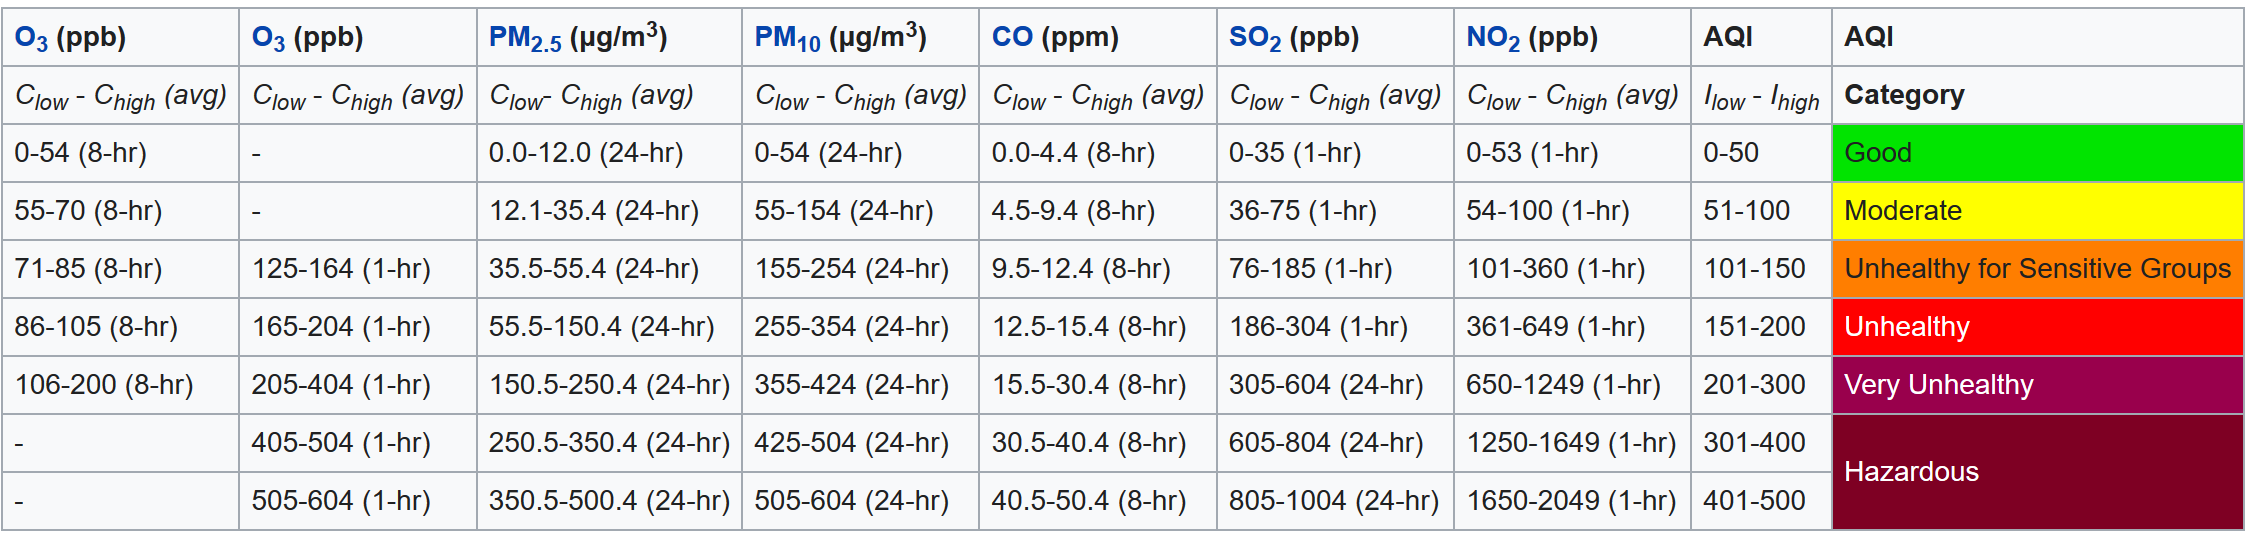

In [24]:
# Read the pollution dataset, only columns that are needed.
def clean_pollution(column_selection, col_dict):
    pollution = pd.read_csv(
        'data/USPollution/pollution_us_2000_2016.csv', 
        dtype={'State Code':'string', 'County Code':'string'},
        usecols=['State Code','County Code', 'Site Num', 'State', 'County', 'City', 'Date Local', 'NO2 AQI', 
                'O3 AQI', 'SO2 AQI', 'CO AQI'],
        parse_dates=['Date Local']
    )

    pollution.sort_values(['Date Local', 'State', 'County'], inplace=True, ignore_index=True)

    pollution['State Code']= pollution['State Code'].apply(lambda x: '{0:0>2}'.format(x)) 

    pollution['County Code']= pollution['County Code'].apply(lambda x: '{0:0>3}'.format(x)) 
    if column_selection == 'State':
        pollution['GEO_ID'] = '0500000US' + pollution['State Code'] + '000'
    elif column_selection == 'County':
        pollution['GEO_ID'] = '0500000US' + pollution['State Code'] + pollution['County Code']
    pollution = pollution.rename(columns = col_dict)
    pollution = count_instances(pollution)
    if column_selection == 'State':
        other_column = 'County'
    else:
        other_column = 'State'
    
    pollution2 = pollution.groupby([column_selection, pd.Grouper(freq='AS', key='Date_Local'),
                                'GEO_ID', other_column]).agg({ 'O3_AQI':np.mean, 'CO_AQI':np.mean, 'NO2_AQI':np.mean,'SO2_AQI':np.mean, 
                                                 'Gd_O3':sum, 'Md_O3':sum, 'UnhSG_O3':sum, 'Unh_O3':sum, 'VUnh_O3':sum, 'Hzrd_O3':sum,
                                                             'Gd_CO':sum, 'Md_CO':sum, 'UnhSG_CO':sum, 'Unh_CO':sum, 'VUnh_CO':sum, 'Hzrd_CO':sum,
                                                             'Gd_NO2':sum, 'Md_NO2':sum, 'UnhSG_NO2':sum, 'Unh_NO2':sum, 'VUnh_NO2':sum, 'Hzrd_NO2':sum,
                                                             'Gd_SO2':sum, 'Md_SO2':sum, 'UnhSG_SO2':sum, 'Unh_SO2':sum, 'VUnh_SO2':sum, 'Hzrd_SO2':sum}).reset_index()

    pollution2.sort_values([column_selection, 'Date_Local'], ignore_index=True, inplace=True)
   
    return pollution2

In [25]:
col_dict = {'State Code':'State_Code', 'County Code':'County_Code', 'Site Num':'Site_Num',
            'State':'State', 'County':'County', 'City':'City', 'Date Local':'Date_Local', 
            'NO2 AQI':'NO2_AQI', 'O3 AQI':'O3_AQI', 'SO2 AQI':'SO2_AQI', 'CO AQI':'CO_AQI', 
            'GEO_ID':'GEO_ID'}

In [26]:
dirty = clean_pollution('County', col_dict)

In [27]:
dirty.tail()

,County,Date_Local,GEO_ID,State,O3_AQI,CO_AQI,NO2_AQI,SO2_AQI,Gd_O3,Md_O3,UnhSG_O3,Unh_O3,VUnh_O3,Hzrd_O3,Gd_CO,Md_CO,UnhSG_CO,Unh_CO,VUnh_CO,Hzrd_CO,Gd_NO2,Md_NO2,UnhSG_NO2,Unh_NO2,VUnh_NO2,Hzrd_NO2,Gd_SO2,Md_SO2,UnhSG_SO2,Unh_SO2,VUnh_SO2,Hzrd_SO2
1184,York,2012-01-01,0500000US42133,Pennsylvania,35.188920,4.164773,23.133523,5.926346,1268,120,20,0,0,0,704,0,0,0,0,0,1392,16,0,0,0,0,704,2,0,0,0,0
1185,York,2013-01-01,0500000US42133,Pennsylvania,36.442568,2.158784,20.035473,5.195286,1040,144,0,0,0,0,592,0,0,0,0,0,1176,8,0,0,0,0,594,0,0,0,0,0
1186,York,2014-01-01,0500000US42133,Pennsylvania,35.116054,1.690522,21.450677,7.861004,954,80,0,0,0,0,517,0,0,0,0,0,1030,4,0,0,0,0,516,2,0,0,0,0
1187,York,2015-01-01,0500000US42133,Pennsylvania,37.396166,2.158147,21.493610,7.764331,1052,196,4,0,0,0,626,0,0,0,0,0,1240,12,0,0,0,0,626,2,0,0,0,0
1188,York,2016-01-01,0500000US42133,Pennsylvania,29.957831,2.415663,25.102410,6.380952,328,4,0,0,0,0,166,0,0,0,0,0,322,10,0,0,0,0,168,0,0,0,0,0


In [28]:
dirty.shape

(1189, 32)

In [29]:
len(pd.unique(dirty['County']))

133

In [30]:
dirty['County'].value_counts()

Orange            33
Suffolk           27
Adams             20
Cook              17
San Bernardino    17
                  ..
Union              1
Duchesne           1
Monroe             1
Athens             1
Richland           1
Name: County, Length: 133, dtype: int64

In [31]:
len(pd.unique(dirty['State']))

47

In [32]:
dirty['State'].value_counts()

California              235
Pennsylvania            203
Texas                    66
New York                 50
Oklahoma                 42
Arizona                  34
Illinois                 33
Connecticut              31
Virginia                 30
Colorado                 29
Kansas                   27
North Carolina           25
Maryland                 21
New Jersey               21
Iowa                     21
Kentucky                 20
Missouri                 19
Maine                    19
Louisiana                19
Florida                  19
District Of Columbia     17
Indiana                  17
Massachusetts            16
Ohio                     15
Michigan                 13
New Hampshire            12
Wyoming                  12
Arkansas                 10
Nevada                   10
Tennessee                 9
North Dakota              9
Utah                      9
Oregon                    9
South Carolina            7
Georgia                   7
South Dakota        

<h3>Pollution Dataset Results</h3>
Not so lucky with this dataset, though we started with 1.75mil observations, the number of counties is limited to 133 (there are 3,141 in the USA).<br>
Additionally, the number of observations per  County or State are skewed. We can live with that, but this highlighted one of my biggest learnings of the project.<br>
<b>Know what is in your data!</b><br>
Ideally, I'd go and find a better set of data to cover additional counties (should include PM2.5 and PM10), but this late in the game, I will forge ahead with what I have.

In [33]:
dirty.shape

(1189, 32)

In [34]:
income.shape

(43974, 5)

<h3>Merging the Datasets</h3>
<ul>
    <li>Dirty and income sets are uneven in length, so an inner join makes sense.
    <li>GEO_ID is common for both sets, but is not a unique value per row.
    <li>Will merge on Date and GEO_ID which in combination should provide unique data to merge on.
</ul>

In [35]:
final = pd.merge(left=income, right=dirty, how='inner', left_on=['Year', 'GEO_ID'], right_on=['Date_Local', 'GEO_ID'])

<AxesSubplot:xlabel='Unh_SO2', ylabel='Median_Household_Income'>

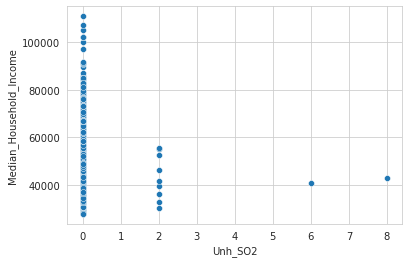

In [36]:
sns.scatterplot(data=final, x='Unh_SO2', y='Median_Household_Income')

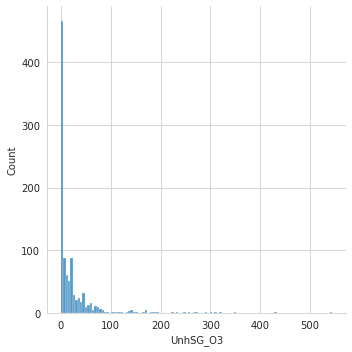

In [42]:
sns.displot(final['UnhSG_O3'], kde = False)

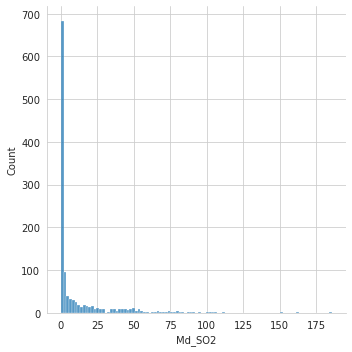

In [40]:
sns.displot(dirty['Md_SO2'], kde = False)

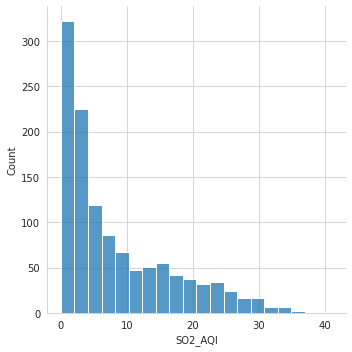

In [43]:
sns.displot(dirty['SO2_AQI'], kde = False)

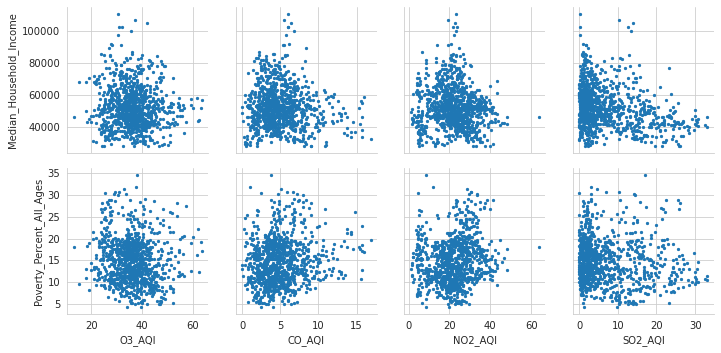

In [44]:
x = sns.PairGrid(final, x_vars=['O3_AQI', 'CO_AQI', 'NO2_AQI', 'SO2_AQI'], y_vars=['Median_Household_Income', 'Poverty_Percent_All_Ages'])
x = x.map(plt.scatter, s=5)                                                                               

Looking at the PairGrid of AQI vs Median Household Income, I have confirmed that averaging the pollution values 'dilutes' the instances of heavier pollution.
Will need to keep this in mind during modelling, perhaps better to not use the average columns for modelling at all.

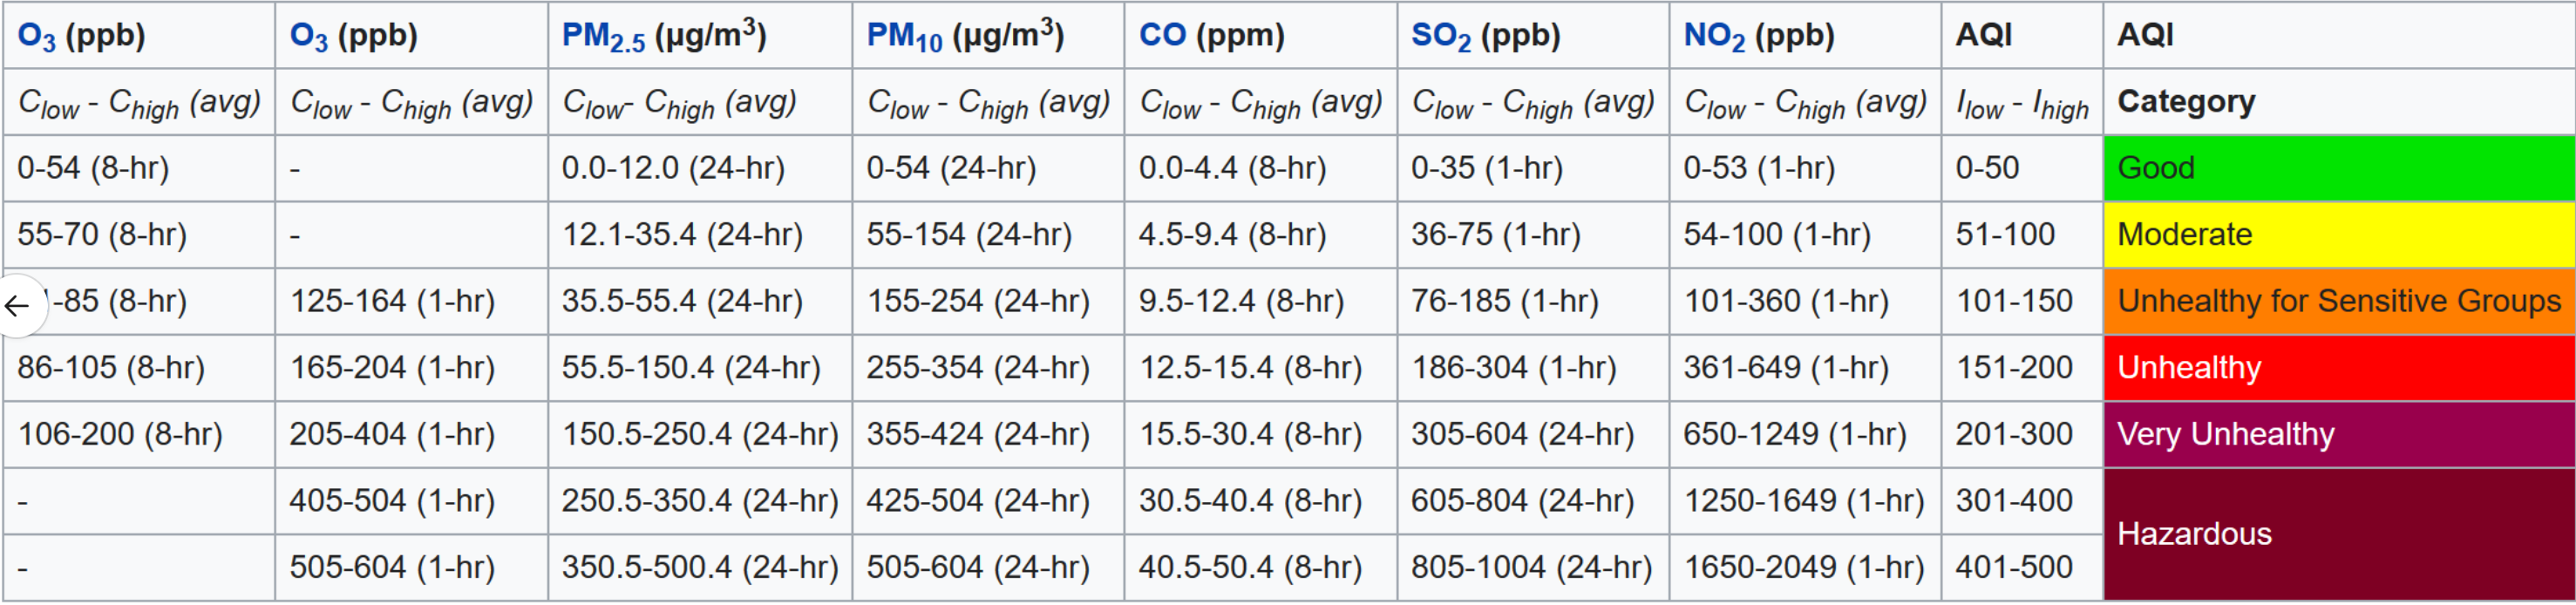

<AxesSubplot:xlabel='UnhSG_NO2', ylabel='Poverty_Percent_All_Ages'>

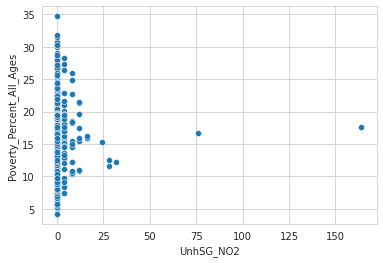

In [45]:
 sns.scatterplot(data=final, x='UnhSG_NO2', y='Poverty_Percent_All_Ages')

<AxesSubplot:xlabel='Unh_SO2', ylabel='Poverty_Percent_All_Ages'>

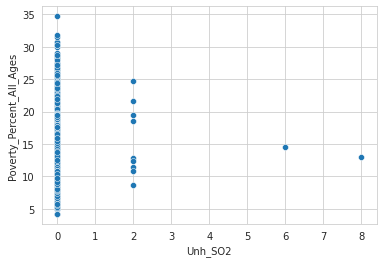

In [46]:
 sns.scatterplot(data=final, x='Unh_SO2', y='Poverty_Percent_All_Ages')

<AxesSubplot:xlabel='UnhSG_CO', ylabel='Poverty_Percent_All_Ages'>

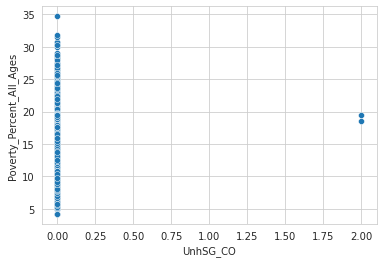

In [47]:
 sns.scatterplot(data=final, x='UnhSG_CO', y='Poverty_Percent_All_Ages')

<AxesSubplot:xlabel='Unh_O3', ylabel='Poverty_Percent_All_Ages'>

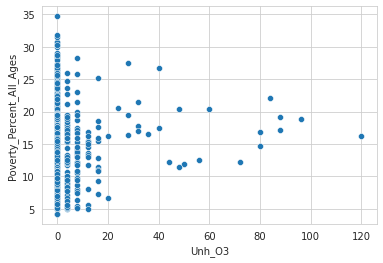

In [48]:
 sns.scatterplot(data=final, x='Unh_O3', y='Poverty_Percent_All_Ages')

<AxesSubplot:xlabel='VUnh_O3', ylabel='Poverty_Percent_All_Ages'>

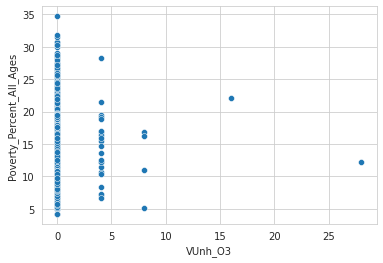

In [49]:
 sns.scatterplot(data=final, x='VUnh_O3', y='Poverty_Percent_All_Ages')

<AxesSubplot:>

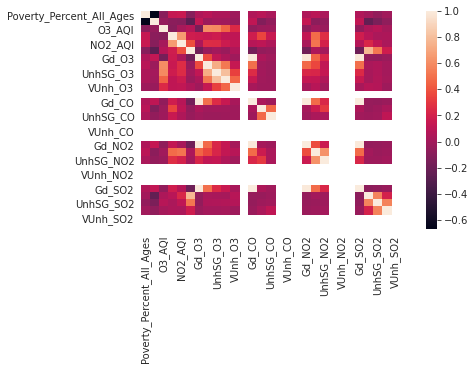

In [50]:
sns.heatmap(final.corr())

Having gone through all of the AQI hits for Very Unhealthy and Hazardous, I've found that only O3 has hits for Very Unhealthy and there are no hits at all for Hazardous (seems a bit strange given all of the fires in California etc). Therefore, I'll only use the O3 column for Very Unhealthy and none of the Hazardous hit columns for modelling.

In [51]:
final.tail()

,Name,Poverty_Percent_All_Ages,Median_Household_Income,GEO_ID,Year,County,Date_Local,State,O3_AQI,CO_AQI,NO2_AQI,SO2_AQI,Gd_O3,Md_O3,UnhSG_O3,Unh_O3,VUnh_O3,Hzrd_O3,Gd_CO,Md_CO,UnhSG_CO,Unh_CO,VUnh_CO,Hzrd_CO,Gd_NO2,Md_NO2,UnhSG_NO2,Unh_NO2,VUnh_NO2,Hzrd_NO2,Gd_SO2,Md_SO2,UnhSG_SO2,Unh_SO2,VUnh_SO2,Hzrd_SO2
985,York County,10.6,55646.0,0500000US42133,2012-01-01,York,2012-01-01,Pennsylvania,35.188920,4.164773,23.133523,5.926346,1268,120,20,0,0,0,704,0,0,0,0,0,1392,16,0,0,0,0,704,2,0,0,0,0
986,York County,10.8,56963.0,0500000US42133,2013-01-01,York,2013-01-01,Pennsylvania,36.442568,2.158784,20.035473,5.195286,1040,144,0,0,0,0,592,0,0,0,0,0,1176,8,0,0,0,0,594,0,0,0,0,0
987,York County,10.2,58471.0,0500000US42133,2014-01-01,York,2014-01-01,Pennsylvania,35.116054,1.690522,21.450677,7.861004,954,80,0,0,0,0,517,0,0,0,0,0,1030,4,0,0,0,0,516,2,0,0,0,0
988,York County,10.4,58527.0,0500000US42133,2015-01-01,York,2015-01-01,Pennsylvania,37.396166,2.158147,21.493610,7.764331,1052,196,4,0,0,0,626,0,0,0,0,0,1240,12,0,0,0,0,626,2,0,0,0,0
989,York County,9.8,62305.0,0500000US42133,2016-01-01,York,2016-01-01,Pennsylvania,29.957831,2.415663,25.102410,6.380952,328,4,0,0,0,0,166,0,0,0,0,0,322,10,0,0,0,0,168,0,0,0,0,0


In [52]:
final.shape

(990, 36)

<h3>Modelling</h3>
This is a regression problem, one modelling option is multiple Linear Regression, the other Decision Tree Regressors. 
I will go through the following modelling techniques:
<ol>
    <li>statsmodels Linear Regression using OLS.
    <li>sklearn Linear Regression.
    <li>time permitting, I will try a Decision Forest Regressor.
</ol>

<h3>statsmodels Modelling</h3>

In [53]:
#list of features for modelling.
model_formula = 'Median_Household_Income ~ O3_AQI + CO_AQI + NO2_AQI + SO2_AQI + Gd_O3 + Md_O3 + UnhSG_O3 + Unh_O3 + VUnh_O3 + Gd_CO + Md_CO + UnhSG_CO + Gd_NO2 + Md_NO2 + UnhSG_NO2 + Unh_NO2 + Gd_SO2 + Md_SO2 + UnhSG_SO2 + Unh_SO2'

In [54]:
model = smf.ols(data=final, formula=model_formula).fit()

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Median_Household_Income   R-squared:                       0.137
Model:                                 OLS   Adj. R-squared:                  0.121
Method:                      Least Squares   F-statistic:                     8.538
Date:                     Mon, 29 Mar 2021   Prob (F-statistic):           1.17e-21
Time:                             21:11:35   Log-Likelihood:                -10702.
No. Observations:                      990   AIC:                         2.144e+04
Df Residuals:                          971   BIC:                         2.153e+04
Df Model:                               18                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.565e+04   3521.601     12.963      0.000    3.87e+04    5.26e+04
O3_AQI       138.4669     85.376      1.622      0.105     -29.077     306.010
CO_AQI       -90.5099    208.495     -0.434      0.664    -499.662     318.642
NO2_AQI      217.0783     69.441      3.126      0.002      80.806     353.351
SO2_AQI     -450.5729     95.278     -4.729      0.000    -637.547    -263.599
Gd_O3        -49.8308     92.430     -0.539      0.590    -231.216     131.554
Md_O3        -74.3060     91.989     -0.808      0.419    -254.827     106.215
UnhSG_O3      -6.9688     93.769     -0.074      0.941    -190.983     177.045
Unh_O3      -132.0114    123.914     -1.065      0.287    -375.182     111.160
VUnh_O3     -310.3343    319.799     -0.970      0.332    -937.911     317.243
Gd_CO        483.0904    368.178      1.312      0.190    -239.425    1205.606
Md_CO       -289.7790    429.361     -0.675      0.500   -1132.361     552.803
UnhSG_CO    -431.1634   4987.717     -0.086      0.931   -1.02e+04    9356.783
Gd_NO2      -210.4864    135.329     -1.555      0.120    -476.057      55.084
Md_NO2      -228.3897    135.998     -1.679      0.093    -495.274      38.494
UnhSG_NO2   -134.5751    159.215     -0.845      0.398    -447.019     177.869
Unh_NO2     2.877e-13   1.43e-12      0.201      0.841   -2.52e-12     3.1e-12
Gd_SO2        43.3099    162.585      0.266      0.790    -275.749     362.369
Md_SO2       -16.5590    168.130     -0.098      0.922    -346.499     313.381
UnhSG_SO2    171.6789    232.498      0.738      0.460    -284.578     627.935
Unh_SO2     -537.2525   1316.465     -0.408      0.683   -3120.697    2046.192
==============================================================================
Omnibus:                      135.812   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.749
Skew:                           0.853   Prob(JB):                     2.63e-54
Kurtosis:                       4.753   Cond. No.                     1.68e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.72e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [56]:
#polynomial formula
model_formula_poly = 'Median_Household_Income ~ O3_AQI + np.power(CO_AQI, 2) + np.power(NO2_AQI, 3) + np.power(SO2_AQI, 4) + np.power(Gd_O3, 5) + np.power(Md_O3, 6) + np.power(UnhSG_O3, 7) + np.power(Unh_O3, 8) + np.power(VUnh_O3, 9) + np.power(Gd_CO, 10) + np.power(Md_CO, 11) + np.power(UnhSG_CO, 12) + np.power(Gd_NO2, 13) + np.power(Md_NO2, 14) + np.power(UnhSG_NO2, 15) + np.power(Unh_NO2, 16) + np.power(Gd_SO2, 17) + np.power(Md_SO2, 18) + np.power(UnhSG_SO2, 19) + np.power(Unh_SO2, 20)'

In [57]:
model_poly = smf.ols(data=final, formula=model_formula_poly).fit()

In [58]:
model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Median_Household_Income   R-squared:                      -9.138
Model:                                 OLS   Adj. R-squared:                 -9.284
Method:                      Least Squares   F-statistic:                    -62.77
Date:                     Mon, 29 Mar 2021   Prob (F-statistic):               1.00
Time:                             21:11:43   Log-Likelihood:                -11921.
No. Observations:                      990   AIC:                         2.387e+04
Df Residuals:                          975   BIC:                         2.395e+04
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                3.188e-05   1.49e-06     21.329      0.000    2.89e-05    3.48e-05
O3_AQI                     -0.0029      0.000    -21.045      0.000      -0.003      -0.003
np.power(CO_AQI, 2)        -0.0014   7.07e-05    -20.398      0.000      -0.002      -0.001
np.power(NO2_AQI, 3)        1.2767      0.060     21.288      0.000       1.159       1.394
np.power(SO2_AQI, 4)        0.0186      0.011      1.742      0.082      -0.002       0.040
np.power(Gd_O3, 5)       8.312e-15   1.49e-15      5.562      0.000    5.38e-15    1.12e-14
np.power(Md_O3, 6)       1.985e-14   3.19e-14      0.622      0.534   -4.28e-14    8.25e-14
np.power(UnhSG_O3, 7)        5e-15   1.07e-14      0.466      0.642   -1.61e-14    2.61e-14
np.power(Unh_O3, 8)      5.673e-13   1.01e-12      0.560      0.576   -1.42e-12    2.56e-12
np.power(VUnh_O3, 9)    -6.701e-10   3.94e-09     -0.170      0.865    -8.4e-09    7.06e-09
np.power(Gd_CO, 10)     -8.711e-16   2.55e-16     -3.419      0.001   -1.37e-15   -3.71e-16
np.power(Md_CO, 11)      3.305e-14   9.87e-14      0.335      0.738   -1.61e-13    2.27e-13
np.power(UnhSG_CO, 12)      0.0007   3.51e-05     21.194      0.000       0.001       0.001
np.power(Gd_NO2, 13)     5.944e-16   2.82e-16      2.109      0.035    4.12e-17    1.15e-15
np.power(Md_NO2, 14)     1.342e-15   5.22e-16      2.573      0.010    3.18e-16    2.37e-15
np.power(UnhSG_NO2, 15) -4.899e-15   3.04e-15     -1.614      0.107   -1.09e-14    1.06e-15
np.power(Unh_NO2, 16)   -2.827e-16   1.33e-17    -21.192      0.000   -3.09e-16   -2.57e-16
np.power(Gd_SO2, 17)     1.131e-16   2.53e-16      0.446      0.656   -3.84e-16     6.1e-16
np.power(Md_SO2, 18)     1.501e-15   5.99e-16      2.507      0.012    3.26e-16    2.68e-15
np.power(UnhSG_SO2, 19)  9.219e-16   1.47e-15      0.626      0.532   -1.97e-15    3.81e-15
np.power(Unh_SO2, 20)   -1.138e-15   3.69e-14     -0.031      0.975   -7.35e-14    7.12e-14
==============================================================================
Omnibus:                      493.706   Durbin-Watson:                   0.391
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7109.951
Skew:                          -1.920   Prob(JB):                         0.00
Kurtosis:                      15.555   Cond. No.                     1.43e+33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.56e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [59]:
#log-log formula
loglog_formula = 'np.log(Median_Household_Income) ~ np.log(O3_AQI + CO_AQI + NO2_AQI + SO2_AQI + Gd_O3 + Md_O3 + UnhSG_O3 + Unh_O3 + VUnh_O3 + Gd_CO + Md_CO + UnhSG_CO + Gd_NO2 + Md_NO2 + UnhSG_NO2 + Unh_NO2 + Gd_SO2 + Md_SO2 + UnhSG_SO2 + Unh_SO2)'

In [60]:
model_log = smf.ols(data=final, formula=loglog_formula).fit()

In [61]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     np.log(Median_Household_Income)   R-squared:                       0.005
Model:                                         OLS   Adj. R-squared:                  0.004
Method:                              Least Squares   F-statistic:                     4.655
Date:                             Mon, 29 Mar 2021   Prob (F-statistic):             0.0312
Time:                                     21:12:10   Log-Likelihood:                 9.3590
No. Observations:                              990   AIC:                            -14.72
Df Residuals:                                  988   BIC:                            -4.923
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
========================================================================================================================================================================================================================================================================
                                                                                                                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                                                                               10.6485      0.087    122.084      0.000      10.477      10.820
np.log(O3_AQI + CO_AQI + NO2_AQI + SO2_AQI + Gd_O3 + Md_O3 + UnhSG_O3 + Unh_O3 + VUnh_O3 + Gd_CO + Md_CO + UnhSG_CO + Gd_NO2 + Md_NO2 + UnhSG_NO2 + Unh_NO2 + Gd_SO2 + Md_SO2 + UnhSG_SO2 + Unh_SO2)     0.0229      0.011      2.157      0.031       0.002       0.044
==============================================================================
Omnibus:                        1.878   Durbin-Watson:                   0.486
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.875
Skew:                           0.106   Prob(JB):                        0.392
Kurtosis:                       2.981   Cond. No.                         95.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h3>Statsmodels Results</h3>
Given that the best R-squared value for the statsmodels models was 0.137 and the worst was 0.005, I'll move directly onto sklearn's regression to see if we can get better results.<br>
I believe the multi-collinearity issues are a result of the distribution of AQI hits being centred around 0. If that is the case, we should see similar results with sklearn linear regression. Another method, Partial Least Squares (PLS) might perform better.

<h3>sklearn Modelling</h3>

In [62]:
X = final[['O3_AQI', 'CO_AQI', 'NO2_AQI',
           'SO2_AQI', 'Gd_O3', 'Md_O3', 'UnhSG_O3',
           'Unh_O3', 'VUnh_O3', 'Gd_CO', 'Md_CO',
           'UnhSG_CO', 'Gd_NO2', 'Md_NO2', 'UnhSG_NO2',
           'Unh_NO2', 'Gd_SO2', 'Md_SO2', 'UnhSG_SO2', 'Unh_SO2']].values
y = final[['Median_Household_Income']].values

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [64]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [65]:
regressor_coef_= regressor.coef_.flatten

In [66]:
print(regressor.coef_)

[[ 1.46331674e+02 -7.71364195e+01  2.26149321e+02 -3.88721446e+02
   2.39983151e+14  2.39983151e+14  2.39983151e+14  2.39983151e+14
   2.39983151e+14  4.32488413e+02 -3.70551458e+02 -7.35773682e+02
  -2.39983151e+14 -2.39983151e+14 -2.39983151e+14 -1.96239456e+10
   7.26160735e+00 -7.76521010e+01  1.79304517e+02 -1.11134395e+03]]


In [67]:
y_pred = regressor.predict(X_test)

In [68]:
y_pred = y_pred.flatten()

In [69]:
y_test = y_test.flatten()

In [70]:
y_pred.shape

(198,)

<h3>Validating the Results</h3>

In [71]:
data = {'Actual':y_test, 'Predicted':y_pred}
results = pd.DataFrame(data)

In [72]:
results2 = results.head(25)

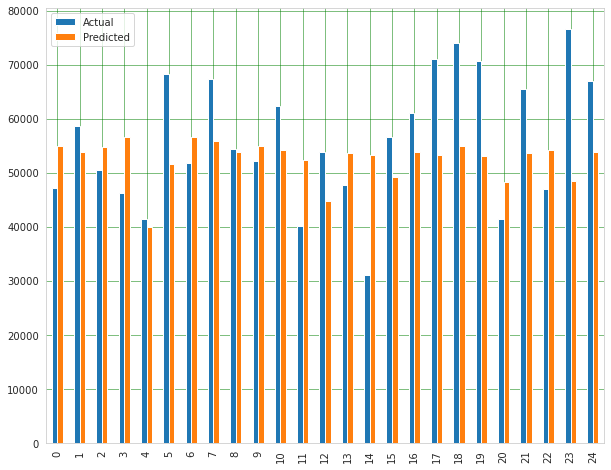

In [73]:
results2.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [74]:
results3 = results.tail(25)

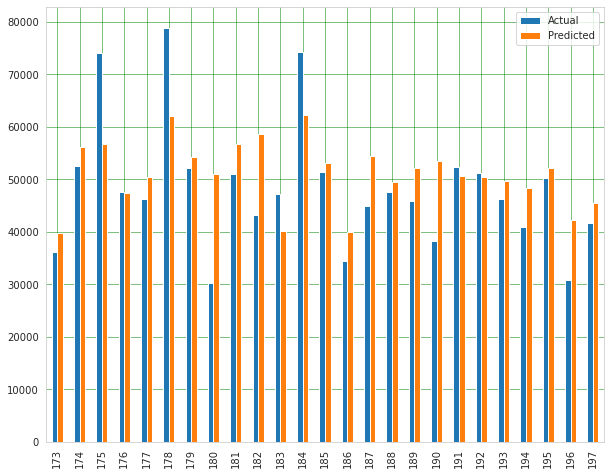

In [75]:
results3.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [76]:
print('R-Squared Value:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-Squared Value: 0.15898404814349865
Mean Absolute Error: 8724.681978603048
Mean Squared Error: 129659310.21248378
Root Mean Squared Error: 11386.804214198282


<h3>sklearn results</h3>
Based on the results above and the validation tests, the null hypothesis cannot be rejected on the current model and data.

<h3>Conclusion</h3>
The way the modelling for this project has been setup is not an example of best practices. There are multiple issues, but one of the larges is that the pollution data essentially disappears, there are not enough heavy pollution readings to be worthwhile and as a result, the data is essentially zero or asymptotic to zero for the large majority of samples.

Besides not giving us anything that is useful, it also introduces a significant problem for multi variable linear regression modelling, and that is multicollinearity. Where two or more variables are highly related to each other. In this example, essentially all of our pollution data points share the same value, zero or very close to it.

<b>Based on the current data and modelling techniques, our theory is not supported and the null hypothesis cannot be rejected.</b>
<br>sklearn has provided the best R-Squared value with 0.158, however, this does not indicate a good fit. 
The predicted values are between 8,727 and 11,391 away from the actual observations.

<h3>Next Steps</h3>
In order to improve the results, the next steps will be:
<ol>
    <li>Find better pollution data.
    <li>Determine the best way to aggregate longterm pollution readings.
    <li>Add features and potentially remove some others to create a better model.
    <li>Use Principle Component Analysis to reduce collinearity.
    
  